## NLP中的Mask使用

在NLP中Mask是一个很常规操作，也有多种应用场景和形式，下面进行总结：

* 处理非定长序列
    * RNN中的Mask
    * Attention中的Mask

* 防止标签泄露
    * Transformer中的Mask
    * BERT中的Mask
    * XLNet中的Mask
    
### Mask的作用

对于NLP中mask的作用先做结论：

1. padding mask: 处理非定长序列，区分 padding 和非 padding 部分，如在RNN等模型和Attention机制中的应用等。

2. sequence mask: 防止标签泄露， 如: Transformer decoder中的mask 矩阵，BERT中的[Mask]位，XLNet中的mask矩阵等。

PS:padding mask和sequence mask非官方命名

### 处理非定长序列

在NLP中，文本一般是不定长的，所以在进行batch训练之前，要先进行长度的统一，过长的句子可以通过truncating截断到固定的长度，过短的句子可以通过padding增加到固定的长度，但是padding 对应的字符只是为了统一长度，并没有实际价值，因此希望在之后的计算中屏蔽他们，这时候就需要Mask.

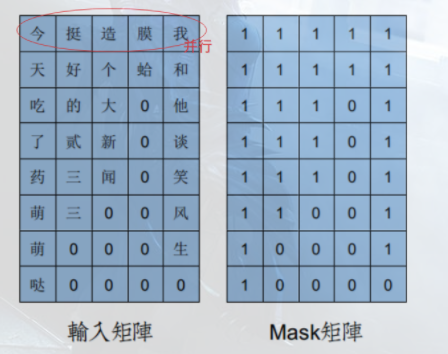

上图为中文场景下，一个 batch=5 的，以字为单位的输入矩阵（也可以在分词后以词为单位）和 mask 矩阵，左图已经将文本 padding 到统一长度了，右图中的1表示有效字，0代表无效字。

### RNN 中的Mask

对于RNN等模型，本身是可以直接处理不定长数据的，因此它不需要提前告知 sequence length，如下是pytorch下的LSTM定义：
`nn.LSTM(input_size, hidden_size, *args, **kwargs)`

但是在实践中，为了 batch 训练，一般会把不定长的序列 padding 到相同长度，再用 mask 去区分非 padding 部分和 padding 部分。

区分的目的是使得RNN只作用到它实际长度的句子，而不会处理无用的 padding 部分，这样RNN的输出和隐状态都会是对应句子实际的最后一位。另外，对于token级别的任务，也可以通过mask去忽略 padding 部分对应的loss.

不过，在 pytorch 中，对 mask 的具体实现形式不是mask矩阵，而是通过一个句子长度列表来实现的，但本质一样。实现如下，sentence_lens 表示的是这个batch中每一个句子的实际长度.

```
embed_input_x_packed = pack_padded_sequence(embed_input_x, sentence_lens, batch_first=True)
encoder_outputs_packed, (h_last, c_last) = self.lstm(embed_input_x_packed)
encoder_outputs, _ = pad_packed_sequence(encoder_outputs_packed, batch_first=True)
```

在 pytorch 的 Embedding 和 Loss 中也有对 padding 值的设置：

```
# padding_idx (int, optional): If given, pads the output with the embedding vector at 
# `padding_idx` (initialized to zeros) whenever it encounters the index.
embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

# ignore_index (int, optional): Specifies a target value that is ignored
# and does not contribute to the input gradient.
criterion = nn.CrossEntropyLoss(ignore_index=0)
```

### Attention 中的 Mask

在 Attention 机制中，同样需要忽略 padding 部分的影响，这里以transformer encoder中的self-attention为例：

self-attention中，Q和K在点积之后，需要先经过mask再进行softmax，因此，对于要屏蔽的部分，mask之后的输出需要为负无穷，这样softmax之后输出才为0。

```
import math

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.mask_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
```

### 防止标签泄漏

在语言模型中，常常需要从上一个词预测下一个词，但如果在ML中应用self attention或者是同时使用上下文的信息，要想不泄漏要预测的标签信息，就需要用mask 来‘遮盖’它。

下面介绍下Transformer中的 Mask 

#### Transformer中的Mask

Transformer是包括Encoder和Decoder的，Encoder中self-attention的padding mask如上，而Decoder还需要防止标签泄漏，即在t时刻不能看见t时刻之后的信息，因此在上述padding mask的基础上，还要加上sequence mask.

sequence mask 一般是通过生成一个上三角为0的矩阵来实现的，上三角区域对应要mask的部分呢。

在Transformer的Decoder中先不考虑padding mask, 一个包括四个词的句子[A, B, C, D]在计算了相似度scores之后，得到下面第一幅图，将scores的上三角区域mask掉，即替换为负无穷，再softmax得到第三幅图，这样，比如输入B在self-attention之后，也只和A,B有关，而与后续信息无关。

因为在softmax之后的加权平均中: $B'=0.48\*A+0.52\*B$,而$C,D$对$B'$不做贡献。

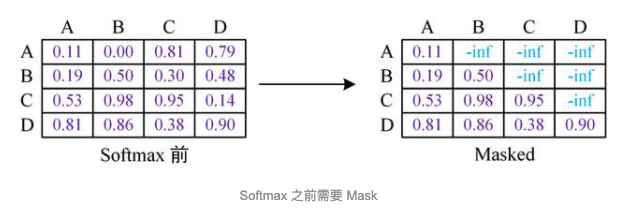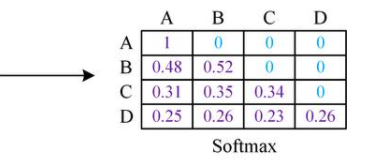



